# Project 5: Making our Network More Efficient

## Analyzing Inefficiencies in our Network

### Importing previous step

In [1]:
from Project2 import *

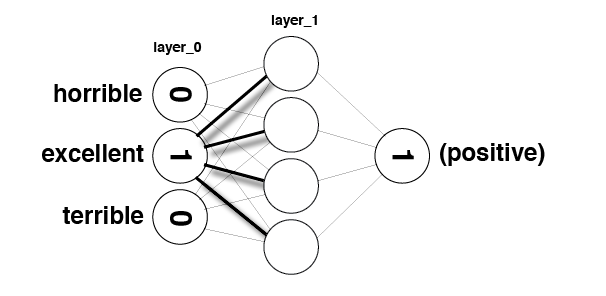

In [2]:
Image(filename='sentiment_network_sparse.png')

In [3]:
layer_0 = np.zeros(10)

In [4]:
layer_0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
layer_0[4] = 1
layer_0[9] = 1

In [6]:
layer_0

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])

In [7]:
weights_0_1 = np.random.randn(10,5)

In [8]:
weights_0_1

array([[ 0.7820938 ,  0.03111752, -0.2576777 ,  2.13146963,  1.90810099],
       [-0.6257686 ,  1.34044459,  0.05559254, -0.17179118, -0.00536486],
       [ 0.95160245, -1.57866312,  1.36153459,  1.24142612, -0.37726718],
       [ 1.97205121,  0.95285532,  1.71956378,  1.04218602, -1.49319029],
       [ 0.31267692,  0.24998088,  0.38093155,  1.28847436,  0.13836409],
       [-1.30911608,  1.93951969,  0.08897924,  0.08657602,  0.14569462],
       [-0.22710371, -0.88973546, -0.08892823,  0.28318808, -0.92037391],
       [-1.679423  ,  0.95599466,  1.55363829,  1.84159286, -1.3064235 ],
       [ 0.40389165, -0.58852026,  1.32714606,  0.16447824,  0.05727303],
       [-0.89845452, -0.00326448,  0.58587585,  1.16359711, -1.378762  ]])

In [9]:
layer_0.dot(weights_0_1)

array([-0.5857776 ,  0.2467164 ,  0.9668074 ,  2.45207146, -1.24039791])

In [10]:
indices = [4,9]

In [11]:
layer_1 = np.zeros(5)

In [12]:
for index in indices:
    layer_1 += (1 * weights_0_1[index])

In [13]:
layer_1

array([-0.5857776 ,  0.2467164 ,  0.9668074 ,  2.45207146, -1.24039791])

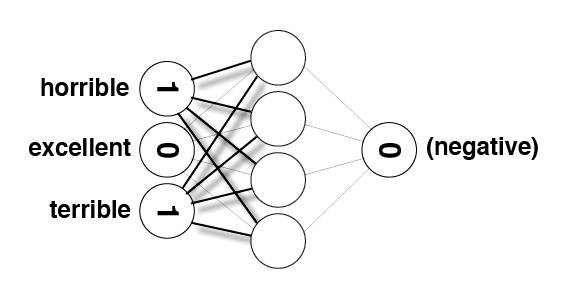

In [14]:
Image(filename='sentiment_network_sparse_2.png')

In [15]:
layer_1 = np.zeros(5)

In [16]:
for index in indices:
    layer_1 += (weights_0_1[index])

In [17]:
layer_1

array([-0.5857776 ,  0.2467164 ,  0.9668074 ,  2.45207146, -1.24039791])

#### TODO: 
Make the SentimentNetwork class more efficient by eliminating unnecessary multiplications and additions that occur during forward and backward propagation. To do that, we can do the following:

* Copy the SentimentNetwork class from the previous project into the following cell.
* Remove the update_input_layer function - we will not need it in this version.
* Modify init_network:
  * We no longer need a separate input layer, so remove any mention of self.layer_0
  * We will be dealing with the old hidden layer more directly, so create self.layer_1, a two-dimensional matrix with shape 1     x hidden_nodes, with all values initialized to zero
* Modify train:
  * Change the name of the input parameter training_reviews to training_reviews_raw. This will help with the next step.
  * At the beginning of the function, we want to preprocess our reviews to convert them to a list of indices (from        
    word2index) that are actually used in the review. Our code should create a local list variable named training_reviews that     should contain a list for each review in training_reviews_raw. Those lists should contain the indices for words found in       the review.
  * Remove call to update_input_layer
  * Use self's  layer_1 instead of a local layer_1 object.
  * In the forward pass, replace the code that updates layer_1 with new logic that only adds the weights for the indices used       in the review.
  * When updating weights_0_1, only update the individual weights that were used in the forward pass.
* Modify run:
  * Remove call to update_input_layer
  * Use self's  layer_1 instead of a local layer_1 object.
  * Much like we did in train, we will need to pre-process the review so we can work with word indices, then update layer_1     by adding weights for the indices used in the review.


The following code is the same as the previous project, with project-specific changes marked with "New for Project 5"

In [18]:
import time
import sys
import numpy as np

# Encapsulate our neural network in a class
class SentimentNetwork:
    def __init__(self, reviews,labels,hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        
        """
        # Assign a seed to our random number generator to ensure we get
        # reproducable results during development 
        np.random.seed(1)

        # process the reviews and their associated labels so that everything
        # is ready for training
        self.pre_process_data(reviews, labels)
        
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels):
        
        # populate review_vocab with all of the words in the given reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                review_vocab.add(word)

        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        # populate label_vocab with all of the words in the given labels.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i

    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights

        # These are the weights between the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))

        # These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        ## New for Project 5: Removed self.layer_0; added self.layer_1
        # The input layer, a two-dimensional matrix with shape 1 x hidden_nodes
        self.layer_1 = np.zeros((1,hidden_nodes))
    
    ## New for Project 5: Removed update_input_layer function
    
    def get_target_for_label(self,label):
        if(label == 'POSITIVE'):
            return 1
        else:
            return 0
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)
    
    ## New for Project 5: changed name of first parameter form 'training_reviews' 
    #                     to 'training_reviews_raw'
    def train(self, training_reviews_raw, training_labels):

        ## New for Project 5: pre-process training reviews so we can deal 
        #                     directly with the indices of non-zero inputs
        training_reviews = list()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))

        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0

        # Remember when we started for printing time statistics
        start = time.time()
        
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            #### Implement the forward pass here ####
            ### Forward pass ###

            ## New for Project 5: Removed call to 'update_input_layer' function
            #                     because 'layer_0' is no longer used

            # Hidden layer
            ## New for Project 5: Add in only the weights for non-zero items
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]

            # Output layer
            ## New for Project 5: changed to use 'self.layer_1' instead of 'local layer_1'
            layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))            
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # Output error
            layer_2_error = layer_2 - self.get_target_for_label(label) # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)

            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            ## New for Project 5: changed to use 'self.layer_1' instead of local 'layer_1'
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            
            ## New for Project 5: Only update the weights that were used in the forward pass
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate # update input-to-hidden weights with gradient descent step

            # Keep track of correct predictions.
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the training process. 
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 5000 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict
        # its label. 
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # Run a forward pass through the network, like in the "train" function.
        
        ## New for Project 5: Removed call to update_input_layer function
        #                     because layer_0 is no longer used

        # Hidden layer
        ## New for Project 5: Identify the indices used in the review and then add
        #                     just those weights to layer_1 
        self.layer_1 *= 0
        unique_indices = set()
        for word in review.lower().split(" "):
            if word in self.word2index.keys():
                unique_indices.add(self.word2index[word])
        for index in unique_indices:
            self.layer_1 += self.weights_0_1[index]
        
        # Output layer
        ## New for Project 5: changed to use self.layer_1 instead of local layer_1
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
        
        # Return POSITIVE for values above greater-than-or-equal-to 0.5 in the output layer;
        # return NEGATIVE for other values
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"

Run the following cell to recreate the network and train it once again.

In [19]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.1)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:11.0% Speed(reviews/sec):807.1 #Correct:1947 #Trained:2642 Training Accuracy:73.6%Progress:20.8% Speed(reviews/sec):735.7 #Correct:3771 #Trained:5001 Training Accuracy:75.4%
Progress:41.6% Speed(reviews/sec):738.7 #Correct:7985 #Trained:10001 Training Accuracy:79.8%
Progress:62.5% Speed(reviews/sec):739.8 #Correct:12258 #Trained:15001 Training Accuracy:81.7%
Progress:83.3% Speed(reviews/sec):743.8 #Correct:16563 #Trained:20001 Training Accuracy:82.8%
Progress:99.9% Speed(reviews/sec):745.4 #Correct:20079 #Trained:24000 Training Accuracy:83.6%

That should have trained much better than the earlier attempts. Running the following cell to test our model with 1000 predictions.

In [20]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:17.6% Speed(reviews/sec):1408. #Correct:157 #Tested:177 Testing Accuracy:88.7%

Progress:65.8% Speed(reviews/sec):1409. #Correct:570 #Tested:659 Testing Accuracy:86.4%

Progress:99.9% Speed(reviews/sec):1258. #Correct:850 #Tested:1000 Testing Accuracy:85.0%